In [1]:
from Environments.SineEnv import SineMarketEnv
from Environments.BoxesMarket import BoxesMarket
from Environments.wrappers.reward_wrapper import CuriosityWrapper

import numpy as np
import matplotlib.pyplot as plt
import ray
import gym
from ray.tune.registry import register_env
from ray.rllib.agents.ppo.ddppo import DEFAULT_CONFIG
from ray.rllib.agents.ppo.ddppo import DDPPOTrainer
import os
import gc
import torch 
import pandas as pd
gc.collect()

80

In [2]:
try:
    ray.init(num_gpus = 1, num_cpus = 4)
except:
    ray.shutdown()
    ray.init(num_gpus = 1, num_cpus = 4)

2020-10-30 21:45:58,641	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2020-10-30 21:45:58,650	WARNING services.py:1617 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66887680 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


In [3]:
trainer_config = DEFAULT_CONFIG.copy()

In [4]:
trainer_config['model']

{'fcnet_hiddens': [256, 256],
 'fcnet_activation': 'tanh',
 'conv_filters': None,
 'conv_activation': 'relu',
 'free_log_std': False,
 'no_final_linear': False,
 'vf_share_layers': True,
 'use_lstm': False,
 'max_seq_len': 20,
 'lstm_cell_size': 256,
 'lstm_use_prev_action_reward': False,
 '_time_major': False,
 'framestack': True,
 'dim': 84,
 'grayscale': False,
 'zero_mean': True,
 'custom_model': None,
 'custom_model_config': {},
 'custom_action_dist': None,
 'custom_preprocessor': None}

In [5]:
trainer_config['model']['use_lstm'] = False
trainer_config['model']['lstm_cell_size'] = 512
trainer_config['num_gpus'] = 0
trainer_config['num_gpus_per_worker'] = 1
trainer_config['num_envs_per_worker'] = 1
trainer_config['gamma'] = 0
trainer_config['entropy_coeff'] = 0
trainer_config['framework'] = 'torch'
trainer_config['num_workers'] = 1
trainer_config['horizon'] = 1000
trainer_config['rollout_fragment_length'] = 1000
trainer_config['model']['framestack'] = False
trainer_config['model']['fcnet_hiddens'] = [1024, 1024]
conf = {'data': 'Data/predictions/',
                                'starting_money': 1000,
                                'starting_stocks': 0,
                                'episode_length': 10000,
                                'commission': 0.0025,
                                'state_trades_num': 10,
                                'action_mode':1,
                                'curiosity_reward':0
                                }
trainer_config['env_config'] = conf
trainer_config['entropy_coeff_schedule'] = 1000

In [6]:
def curiosity_env_create(env_config):
    return CuriosityWrapper(BoxesMarket(env_config))

In [7]:
register_env('CuriosityBoxesMarket', curiosity_env_create)

In [8]:
trainer = DDPPOTrainer(trainer_config, env = 'CuriosityBoxesMarket')

2020-10-30 21:45:58,986	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2020-10-30 21:45:58,994	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=11190) /root/miniconda3/envs/rl/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:65: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=11190)   tensor = torch.from_numpy(np.asarray(item))
2020-10-30 21:46:03,200	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [9]:
best_reward = -np.inf
trainer.save()
hall_of_fame = [0]
last_checkpoint = 0

In [10]:
%%time
for i in range(100):
    print("Training iteration {}...".format(i))
    results = trainer.train()
    this_reward = results['episode_reward_max']
    if this_reward > best_reward:
        best_reward = this_reward
        trainer.save()
        path = trainer.logdir + 'checkpoint_{0}/checkpoint-{0}'.format(last_checkpoint)
        os.remove(path)
        last_checkpoint = i + 1
        hall_of_fame.append(i+1)
        print('New best reward')
        print(best_reward)
    if i % 10 == 0:
        print('Best Reward So Far')
        print(best_reward)      

Training iteration 0...
(pid=11190) ------------------------------Reset called------------------------------
(pid=11190) ------------------------------Reset called------------------------------


/root/miniconda3/envs/rl/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:65: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  tensor = torch.from_numpy(np.asarray(item))


New best reward
5.526146333937678
Best Reward So Far
5.526146333937678
Training iteration 1...
(pid=11190) ------------------------------Reset called------------------------------
Training iteration 2...
(pid=11190) ------------------------------Reset called------------------------------
Training iteration 3...
(pid=11190) ------------------------------Reset called------------------------------
New best reward
17.741929108637805
Training iteration 4...
(pid=11190) ------------------------------Reset called------------------------------
New best reward
19.418306724177686
Training iteration 5...
(pid=11190) ------------------------------Reset called------------------------------
Training iteration 6...
(pid=11190) ------------------------------Reset called------------------------------
Training iteration 7...
(pid=11190) ------------------------------Reset called------------------------------
Training iteration 8...
(pid=11190) ------------------------------Reset called------------------

In [11]:
path = trainer.logdir + 'checkpoint_{0}/checkpoint-{0}'.format(hall_of_fame[-1])

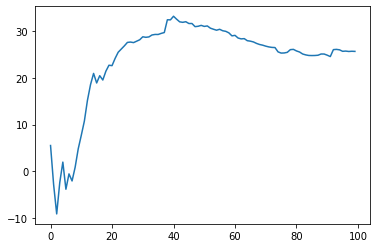

In [12]:
training = pd.read_csv(trainer.logdir + 'progress.csv')
plt.plot(training['episode_reward_mean'])

In [13]:
env = BoxesMarket(conf)
obs = env.reset()

done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(512),torch.zeros(512)]
infos = []
while not done:
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    assets.append(results['assets'])
    prices.append(results['current_price'])
    states.append(obs)
    infos.append(info)
    if i % 100 == 0:
        print('Step: {}/{}'.format(i, 200))
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))

------------------------------Reset called------------------------------
Cumulative reward you've received is: -0.0033574963987139175. Congratulations!
Asset_Gain 50.95783641934872


In [14]:
pure_actions = []
for action in actions:
    pure_actions.append(action[0])
    
actions = pure_actions

IndexError: invalid index to scalar variable.

In [ ]:
buy10 = np.ma.masked_where(np.array(actions) != 0, prices)
buy20 = np.ma.masked_where(np.array(actions) != 1, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
hold = np.ma.masked_where(np.array(actions) != 3, prices)

plt.plot(buy10, c = 'turquoise')
plt.plot(buy20, c = 'lime')
plt.plot(buy50, c = 'green')
plt.plot(hold, c = 'blue')

In [ ]:
plt.plot(assets)

In [ ]:
plt.plot(prices)

In [ ]:
obs = env.test()

done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(512),torch.zeros(512)]
infos = []
market_beaters = []
while not done:
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    assets.append(results['assets'])
    prices.append(results['current_price'])
    states.append(obs)
    infos.append(info)
    market_beaters.append(results['market_beater'])
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))

In [ ]:
plt.plot(market_beaters)
plt.savefig("Graphics/market_beat_1.jpg", dpi=1000)

In [ ]:
pure_actions = []
for action in actions:
    pure_actions.append(action[0])
    
actions = pure_actions

In [ ]:
buy10 = np.ma.masked_where(np.array(actions) != 0, prices)
buy20 = np.ma.masked_where(np.array(actions) != 1, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
hold = np.ma.masked_where(np.array(actions) != 3, prices)

plt.plot(buy10, c = 'turquoise')
plt.plot(buy20, c = 'lime')
plt.plot(buy50, c = 'green')
plt.plot(hold, c = 'blue')
plt.savefig("Graphics/prices_1.jpg", dpi=1000)

In [ ]:
plt.plot(assets)
plt.savefig('Graphics/assets_1.jpg', dpi=1000)

In [ ]:
plt.plot(prices)

In [ ]:
market_beaters[-1]

In [ ]:
from sklearn import preprocessing

In [ ]:
prices_norm = preprocessing.normalize(np.array(prices).reshape(-1,1))
assets_norm = preprocessing.normalize(np.array(assets).reshape(-1,1))

In [ ]:
assets_norm-prices_norm